In [70]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt

In [89]:
data = pd.read_csv("data/playground_data.csv").fillna("")

In [90]:
books = data.book_scroll.unique()
n_books = len(books)
book_lookup = dict(zip(books, range(n_books)))

In [97]:
book = data["book_scroll"] = data.book_scroll.replace(book_lookup).values # county in example
cmpl_constr = data["cmpl_constr"].map({"vc": 0, "prep": 1, "dir-he": 2, "prep + dir-he":3}).astype(int).values # maize yield in example
cmpl_det = data["cmpl_det"].map({"und": 0, "det": 1}).astype(int).values # hybrid seeds in example

In [99]:
#Note: this code is only playaround, the cmpl_constr is not numerical and should not be trated as such for real statistical analysis

data["log_cmpl_constr"] = log_cmpl_constr = np.log(cmpl_constr + 0.1)

<Axes: >

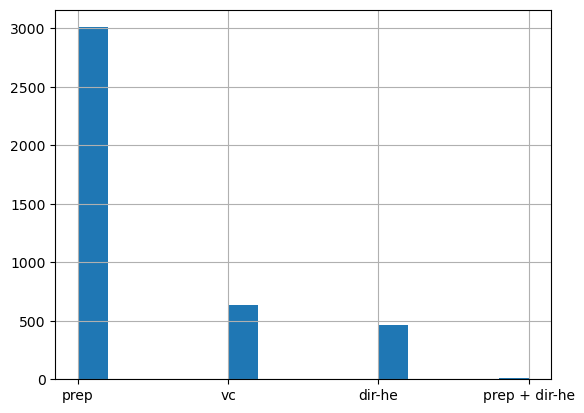

In [105]:
data.cmpl_constr.hist(bins=15)

<Axes: >

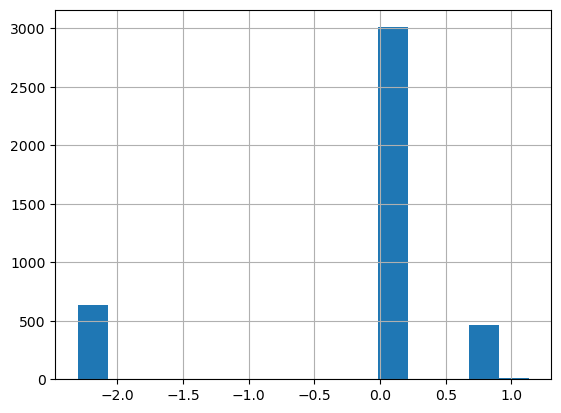

In [106]:
data.log_cmpl_constr.hist(bins=15)

In [100]:
set(cmpl_constr)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3)}

In [93]:
# Pooled model

In [94]:
coords = {"cmpl_det": ["und", "det"], "obs_id": np.arange(cmpl_det.size)}

In [101]:
with pm.Model(coords=coords) as pooled_model:
    cmpl_det_idx = pm.Data("cmpl_det_idx", cmpl_det, dims="obs_id")
    
    a = pm.Normal("a", mu=0, sigma=1.0, dims="cmpl_det")

    theta = a[cmpl_det_idx]
    sigma = pm.HalfCauchy("sigma", 1)

    y = pm.Normal("y", mu=theta, sigma=sigma, observed=log_cmpl_constr, dims="obs_id")

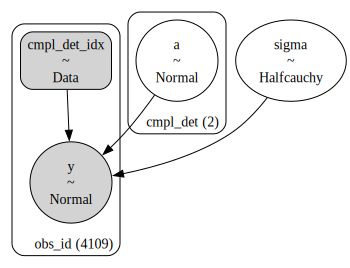

In [102]:
pm.model_to_graphviz(pooled_model)

# grey: observed data
# white: priors

In [ ]:
with pm.Model(coords=coords) as pooled_model:
    cmpl_det_idx = pm.Data("cmpl_det_idx", cmpl_det, dims="obs_id")
    
    a = pm.Normal("a", mu=0, sigma=1.0, dims="cmpl_det")

    theta = a[cmpl_det_idx]
    sigma = pm.HalfCauchy("sigma", 1)

    y = pm.Normal("y", mu=theta, sigma=sigma, observed=log_cmpl_constr, dims="obs_id")

In [107]:
# Unpooled model

In [108]:
coords["Book"] = books

In [110]:
with pm.Model(coords=coords) as unpooled_model:
    cmpl_det_idx = pm.Data("cmpl_det_idx", cmpl_det, dims="obs_id")
    book_idx = pm.Data("books_idx", book, dims="obs_id")
    a = pm.Normal("a", 2.3, sigma=1.0, dims=("Book", "cmpl_det"))

    theta = a[book_idx, cmpl_det_idx]
    sigma = pm.HalfCauchy("sigma", 1)

    y = pm.Normal("y", mu=theta, sigma=sigma, observed=log_cmpl_constr, dims="obs_id")

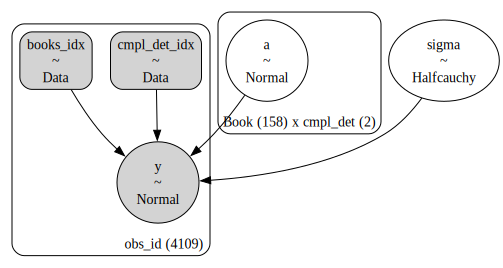

In [111]:
pm.model_to_graphviz(unpooled_model)

In [112]:
# Hierarchical model

In [117]:
coords = {"cmpl_det": ["und", "det"], "obs_id": np.arange(cmpl_det.size), "Book" : books}

In [118]:
with pm.Model(coords=coords) as varying_intercept:
    cmpl_det_idx = pm.Data("cmpl_det_idx", cmpl_det, dims="obs_id")
    book_idx = pm.Data("books_idx", book, dims="obs_id")

    ic_mu = pm.Normal("ic_mu", mu=2, sigma=1)
    ic_sigma = pm.HalfCauchy("ic_sigma", 1.0)

    # Varying intercept
    book_intercept = pm.Normal("book_intercept", mu=ic_mu, sigma=ic_sigma, dims="Book")

    # Common slope
    b = pm.Normal("b", mu=2, sigma=1)

    # Expected value per book
    theta = book_intercept[book_idx] + b * cmpl_det_idx

    # Model error:
    sigma = pm.HalfCauchy("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_cmpl_constr, dims="obs_id")

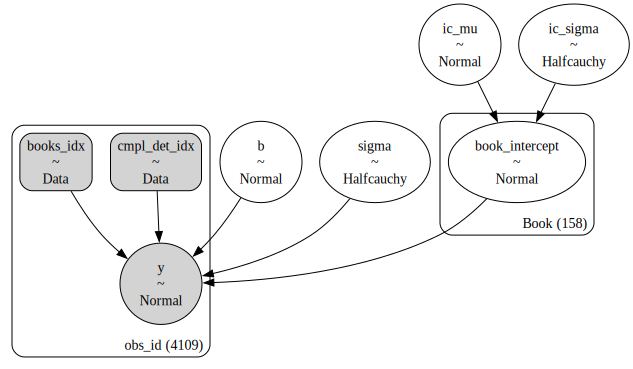

In [119]:
pm.model_to_graphviz(varying_intercept)